In [1]:
:ext NoMonomorphismRestriction FlexibleContexts FlexibleInstances UndecidableInstances
:ext MultiParamTypeClasses TypeFamilies TemplateHaskell GeneralizedNewtypeDeriving DeriveDataTypeable

In [2]:
import Data.Maybe
import Data.Typeable

import Diagrams.Prelude hiding (P)
import Diagrams.Backend.Cairo
import IHaskell.Display
import IHaskell.Display.Diagrams

type D = Diagram B

In [3]:
d :: D -> D
d = frame 0.5

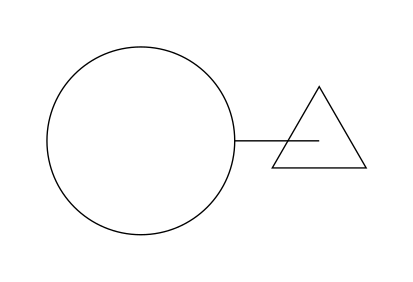

In [4]:
-- testing out juxtaposition of complex types
cr, tc :: (D, [P2 Double])
cr = (circle 1, [p2 (1, 0)])
tc = (triangle 1, [p2 (0, 0)])

d $ let (dia, pts) = hsep 0.4 [cr, tc]
    in  dia <> cubicSpline False pts

# String-drawing stuff

In [5]:
roundCorner :: (TrailLike t, V t ~ V2, RealFloat (N t)) => Direction V2 (N t) -> Direction V2 (N t) -> t
roundCorner p q
  | not (isNaN thetaR), thetaR > 0.1, abs (thetaR - pi) > 0.1
    = arc' radius dir (orientation *^ theta)
  | otherwise = fromOffsets [p', q']
  where (p', q') = (fromDir p, fromDir q)
        orientation = if leftTurn p' q' then 1 else -1
        theta = angleBetween p' q'
        thetaR = theta ^. rad
        radius = 1/tanA (theta ^/ 2)
        dir = (-orientation) *^ direction (perp p')

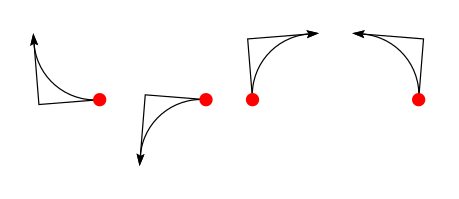

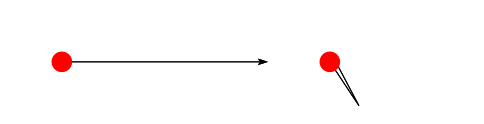

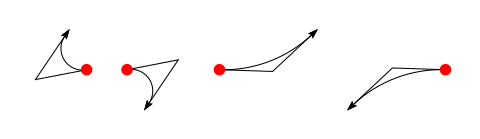

In [6]:
import Diagrams.TwoD.Arrow

testCorner :: (Double, Double, Double, Double) -> D
testCorner (px, py, qx, qy) = showOrigin' (with & oMinSize .~ 0.1) $
    arr (trailFromOffsets [normalize p, normalize q]) <>
        arr (roundCorner (direction p) (direction q))
  where arr t = arrowFromLocatedTrail (t `at` origin)
        (p, q) = (V2 px py, V2 qx qy)

d . hsep 0.5 . map testCorner $ [(-1,0, 0,1), (-1,0, 0,-1), (0,1, 1,0), (0,1, -1,0)]
d . hsep 0.5 . map testCorner $ [(1,0, 1,0), (1,0, -1,0.1)]
d . hsep 0.5 . map testCorner $ [(-1,0, 1,1), (1,0, -1,-1), (1,0, 1,1), (-1,0, -1,-1)]

In [7]:
mapNeigh :: (Maybe a -> a -> Maybe a -> b) -> [a] -> [b]
mapNeigh f = go Nothing
  where go prev [] = []
        go prev (x:[]) = f prev x Nothing : []
        go prev (x:xs@(x':_)) = f prev x (Just x') : go (Just x) xs

fromOffsetsRounded :: [V2 Double] -> Trail V2 Double
fromOffsetsRounded = mconcat . mapNeigh seg
  where
    trim v amt = (1 - amt / norm v) *^ v
    mnorm3 = maybe 0 ((/3) . norm)
    turnSize mo1 mo2 = minimum [0.3, mnorm3 mo1, mnorm3 mo2]
    seg mprev cur mnext =
      maybe mempty corner mprev <> fromOffsets [trim cur (curTS + nextTS)]
      where
        curTS  = turnSize mprev (Just cur)
        nextTS = turnSize (Just cur) mnext
        corner prev =
          roundCorner (direction prev) (direction cur) # scale curTS

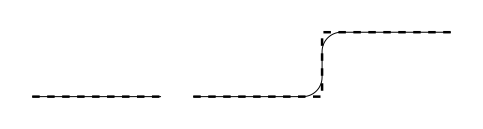

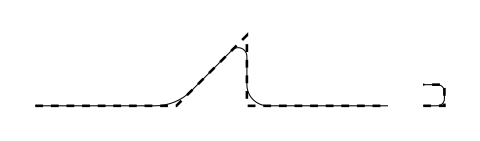

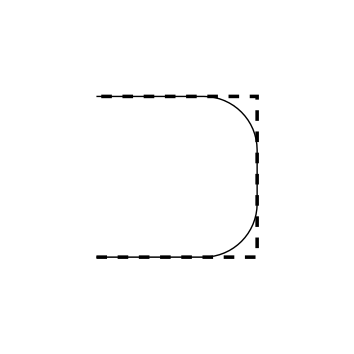

In [8]:
testOR :: [(Double, Double)] -> D
testOR os =
  stroke (trailFromOffsets os') # dashingN [0.03, 0.03] 0 # lw veryThick <>
    stroke (fromOffsetsRounded os')
  where os' = map (\(x, y) -> V2 x y) os

d . hsep 0.5 . map testOR $ [
  [(2, 0)],
  [(2, 0), (0, 1), (2, 0)]]
d . hsep 0.5 . map testOR $ [
  [(2, 0), (1, 1), (0, -1), (2, 0)],
  [(0.3, 0), (0, 0.3), (-0.3, 0)]]
frame 0.03 . testOR $ [(0.05, 0), (0, 0.05), (-0.05, 0)]

In [9]:
stringTrail :: V2 Double -> Trail V2 Double
stringTrail o = fromOffsetsRounded [o1, o2, o3]
  where x :& y = coords o
        o1 = r2 (x / 3, 0)
        o2 = r2 (x / 3, y)
        o3 = o1

# General functionality

In [10]:
-- TODO: types of ins & outs, labels and directedness for strings, maybe braiding?
-- We store the positions of ports as point subdiagrams.
data PortName = In | Out deriving (Show, Eq, Ord, Typeable)
instance IsName PortName
newtype StringDiagram = SD {getSD :: D}
makeWrapped ''StringDiagram

In [11]:
showSD, examineSD :: StringDiagram -> D
showSD (SD d) = dottify red In . dottify blue Out $ d
  where dottify c n = withNameAll n (applyAll . map (atop . dot c . location))
        dot c p = circle 0.05 # lw 0 # fc c # moveTo p
examineSD = showOrigin . bg pink . showSD

showSDs, examineSDs :: [StringDiagram] -> D
showSDs = hsep 1 . map showSD
examineSDs = hsep 1 . map examineSD

instance IHaskellDisplay StringDiagram where
  display = display . frame 0.5 . showSD

In [12]:
namePoints :: IsName nm => nm -> [P2 Double] -> D -> D
namePoints nm = applyAll . map (\p -> namePoint (const p) nm)

mkSD :: [P2 Double] -> [P2 Double] -> D -> StringDiagram
mkSD iports oports = SD . frame 0.125 . alignTL . namePoints In iports . namePoints Out oports

-- Make a node out of the given D, with the given number of in and out ports, spaced evenly.
sdNode :: Int -> Int -> D -> StringDiagram
sdNode inCount outCount d = mkSD iports oports d
  where (loX, hiX) = fromMaybe (0, 0) (extentX d)
        (loY, hiY) = fromMaybe (0, 0) (extentY d)
        {- -- spaced does the right thing for n=0
        spaced x n = map (\i -> p2 (x, fromIntegral i / fromIntegral (n + 1))) [1..n]
        fit = translateY loY . scaleY (hiY - loY)
        iports = spaced loX inCount # fit
        oports = spaced hiX outCount # fit -}
        iports = map (\n -> p2 (loX, loY + 0.375 + fromIntegral n)) [0..inCount - 1]
        oports = map (\n -> p2 (hiX, loY + 0.375 + fromIntegral n)) [0..outCount - 1]

-- TODO: handle arbitrary strings (requires handling name size correctly)
boxNode :: Char -> Int -> Int -> StringDiagram
boxNode label inCount outCount = sdNode inCount outCount box
  where box = (rect 1 h <> text [label]) # fontSize (local 0.5)
        h = 0.75 + fromIntegral (max inCount outCount) - 1

In [13]:
instance Semigroup StringDiagram
instance Monoid StringDiagram where
  mempty = SD mempty
  SD d0 `mappend` SD d1 = SD (d0 === d1)

In [14]:
data Side = LeftS | RightS deriving (Show, Eq, Ord, Typeable)
instance IsName Side

-- TODO: make this more type-safe wrt matching in/out
--- Note that this is left-to-right composition, unlike (.).
sdCompose, (>>>) :: StringDiagram -> StringDiagram -> StringDiagram
sdCompose (SD d0) (SD d1) = SD $ juxt <> strings
  where combo = hsep 0.5 [LeftS .>> d0, RightS .>> d1]
        ports = [LeftS .> In, LeftS .> Out, RightS .> In, RightS .> Out]
        [newIns, midOuts, midIns, newOuts] =
          map (\k -> concat (lookup k (names combo))) ports
        juxt = combo # localize # namePoints In newIns # namePoints Out newOuts
        strings = mconcat (zipWith string midOuts midIns)
        string o i = stroke $ stringTrail (i .-. o) `at` o
(>>>) = sdCompose
infixr 5 >>>

-- Note that since diagrams form a category and not a monoid, we can't make this a true homomorphism!
sdChain :: [StringDiagram] -> StringDiagram
sdChain [] = SD mempty
sdChain sds = foldr1 sdCompose sds

# Specific components

In [15]:
pad375 :: D -> D
pad375 d = let s = strutY 0.375 in s === d === s

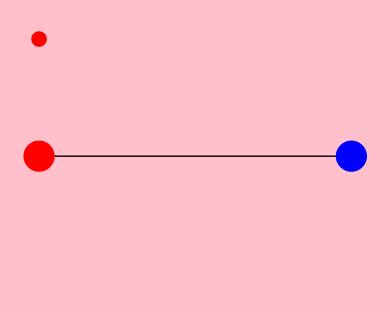

In [16]:
sdID :: StringDiagram
sdID = sdNode 1 1 . pad375 $ seg
  where seg = p2 (0, 0) ~~ p2 (1, 0)

examineSD sdID

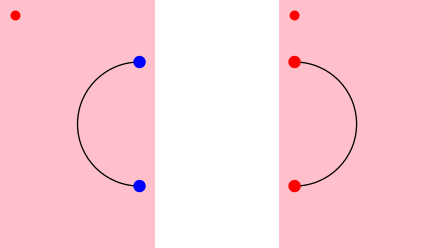

In [17]:
evRad = 0.5
estrut = strutX (1 - evRad)

ev, coev :: StringDiagram
-- TODO make this nicer
ev = sdNode 2 0 . centerX . pad375 $ arc' evRad yDir (-0.5 @@ turn) ||| estrut
coev = sdNode 0 2 . centerX . pad375 $ estrut ||| arc' evRad yDir (0.5 @@ turn)

examineSDs [coev, ev]

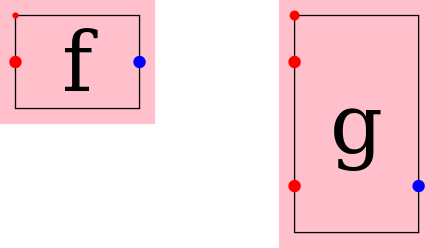

In [18]:
fn = boxNode 'f' 1 1
gn = boxNode 'g' 2 1
examineSDs [fn, gn]

# Testing

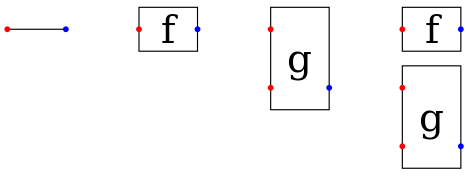

In [19]:
-- id : V → V
-- fn : V → V
-- gn : V ⊗ V → V
-- fn ⊗ gn : V ⊗ V ⊗ V → V ⊗ V
showSDs [sdID, fn, gn, fn <> gn]

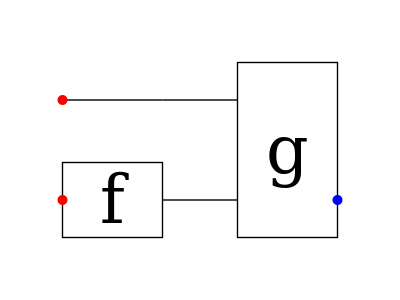

In [20]:
-- g ∘ (id ⊗ f) : V ⊗ V → V
sdID <> fn >>> gn

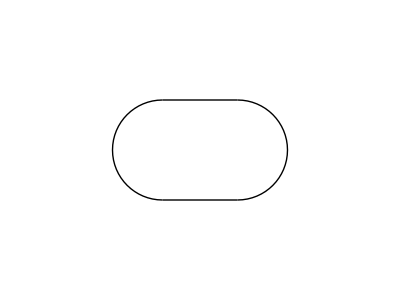

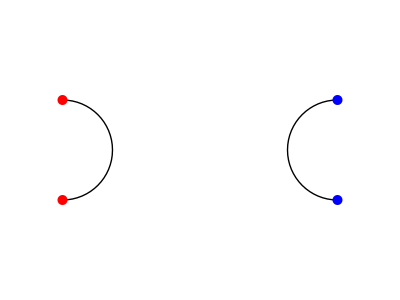

In [21]:
coev >>> ev
ev >>> coev

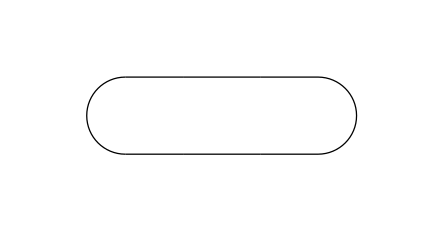

In [22]:
coev >>> sdID <> sdID >>> ev

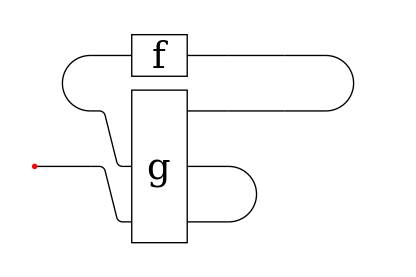

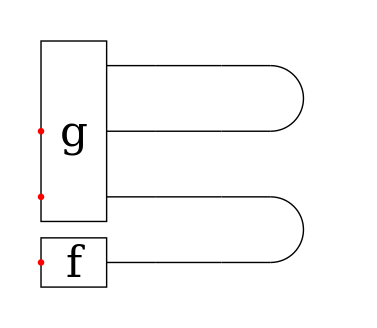

In [23]:
coev <> sdID >>> fn <> boxNode 'g' 2 3 >>> sdID <> sdID <> ev >>> ev
boxNode 'g' 2 3 <> fn >>> sdID <> sdID <> sdID <> sdID >>> ev <> ev

### Kink

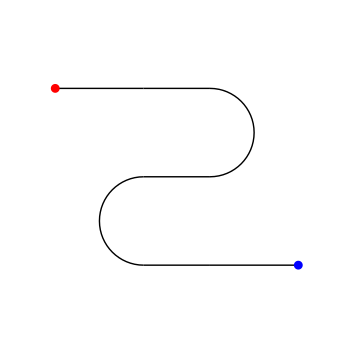

In [24]:
sdID <> coev >>> ev <> sdID

### Trace

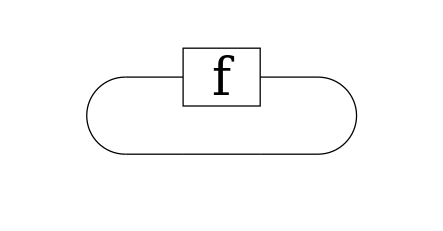

In [25]:
coev >>> fn <> sdID >>> ev

# `Tensor` integration

In [26]:
:ext DataKinds TypeOperators PolyKinds ScopedTypeVariables

In [27]:
import CompactClosed.Classes
import CompactClosed.Operations
import CompactClosed.Free hiding (D)
import qualified CompactClosed.Free as F

In [28]:
import GHC.TypeLits

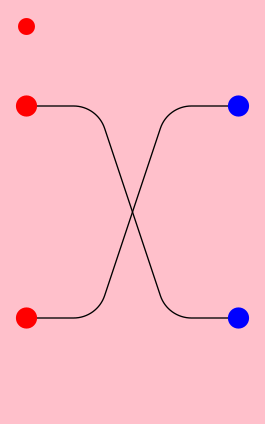

In [29]:
-- TODO make this look nicer!
braidSD = sdNode 2 2 . pad375 $
  stroke (stringTrail (r2 (1, -1))) # translateY 0.5 <>
  stroke (stringTrail (r2 (1,  1))) # translateY (-0.5)
examineSD braidSD

In [30]:
countFactors :: O x => proxy x -> Int
countFactors p = go (reflectFO p)
  where go :: FreeObjV x -> Int
        go NamedV = 1
        go IV = 0
        go (PV xv yv) = go xv + go yv
        go (DV x) = go x

arity :: forall x y proxy. (O x, O y) => proxy x y -> (Int, Int)
arity _ = (countFactors (Proxy :: Proxy x), countFactors (Proxy :: Proxy y))

renderID :: O x => proxy x -> StringDiagram
renderID p = mconcat (replicate (countFactors p) sdID)

In [31]:
renderFree :: Free x y -> StringDiagram
renderFree = go
  where go :: Free x y -> StringDiagram
        -- ...this is partial.
        go l@(Labelled (c:_)) = uncurry (boxNode c) (arity l)

        go i@Id = renderID i
        go (f :>>> g) = go f >>> go g

        go (Bimap f g) = go f <> go g

        go a@Assoc = renderID a
        go ua@Unassoc = renderID ua

        go l@Lunit = renderID l
        go ul@Unlunit = renderID ul
        go r@Runit = renderID r
        go ur@Unrunit = renderID ur

        -- all the rest only work for generator objects!
        go Braid = braidSD
        go Unbraid = braidSD

        go Ev = ev
        go Coev = coev

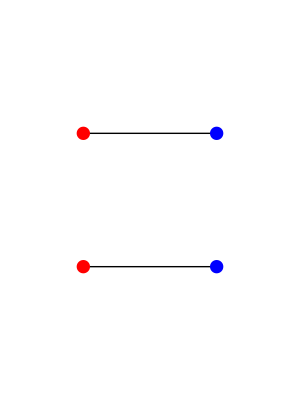

In [32]:
renderFree (id' :: FreeEndo (Named "x" `P` I `P` F.D (Named "y")))

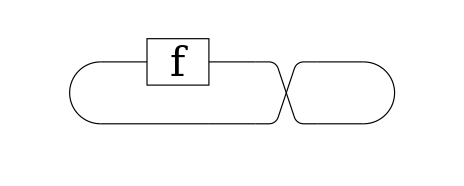

In [33]:
renderFree (CompactClosed.Operations.trace (Labelled "f" :: FreeEndo (Named "x")) :: FreeEndo I)

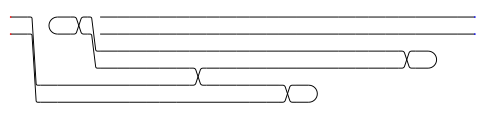

In [37]:
renderFree (CompactClosed.Operations.tensorDual ::
            Free (F.D (Named "x") `P` F.D (Named "y")) (F.D (Named "x" `P` Named "y")))